In [28]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score


In [179]:
train_data=pd.read_csv('Features/train_data.csv',index_col=0)
test_data=pd.read_csv('Features/test_data.csv',index_col=0)

In [180]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'caracteres_usados',
       'menciones_realizadas', 'permite_location', 'use_keyword', 'cita_url',
       'use_hashtag'],
      dtype='object')

In [181]:
features= ['caracteres_usados',
       'menciones_realizadas', 'permite_location', 'use_keyword', 'cita_url',
       'use_hashtag']

In [182]:
X = train_data[features]
Y = train_data['target']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [183]:
kfold = KFold(n_splits=10)

In [184]:
xgbRegressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=1, learning_rate=0.075,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=95, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.8, seed=15, silent=True,
       subsample=0.8)

In [185]:
mejor_score = 0
for train, test in kfold.split(X_train, Y_train):
    train_datas = train_data.iloc[train]
    test_datas = train_data.iloc[test]
    
    X_train_data = train_datas[features]
    Y_train_data = train_datas['target']
    
    X_test_data = test_datas[features]
    Y_test_data = test_datas['target']
    
    xgbRegressor.fit(X_train_data,Y_train_data)
    print(roc_auc_score(Y_test_data,xgbRegressor.predict(X_test_data)))
    if (roc_auc_score(Y_test_data, xgbRegressor.predict(X_test_data))>mejor_score):
        mejor_score = roc_auc_score(Y_test_data,xgbRegressor.predict(X_test_data))
        X_train_optimo = X_train_data
        Y_train_optimo = Y_train_data
        X_test_optimo = X_test_data
        Y_test_optimo = Y_test_data

0.6734453437147834
0.6254167553380152
0.5958541912053397
0.6790001017190519
0.6566228893058161
0.6754528250878615
0.7175046904315197
0.645719983259066
0.5792027375571388
0.7078251714067259


In [186]:
params = {'objective':['binary:logistic'],'colsample_bytree': [0.5,.6,.7,.8,.9,1.0], 'learning_rate': [.07,.075,.08,.085,.09,.095,1.0],
                'max_depth' : [1,2,3,4,5,6,7,8,9,10], 'n_estimators' : [80,85,90,95,100],'seed':[123]}

In [187]:
cv = GridSearchCV(estimator=xgb.XGBRegressor(),param_grid=params,scoring='roc_auc',cv=3)

In [188]:
dmatrix = xgb.DMatrix(data=X_train_optimo[features],label=Y_train_optimo,feature_names=features)

In [165]:
cv.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [189]:
xgbRegressor.fit(X_train_optimo,Y_train_optimo)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1,
             importance_type='gain', learning_rate=0.075, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=95,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8,
             seed=15, silent=True, subsample=0.8, verbosity=1)

In [190]:
roc_auc_score(Y_test_optimo,xgbRegressor.predict(X_test_optimo))

0.7175046904315197

In [191]:
xg_reg = xgb.train(params={'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bytree':1, 'gamma':1,'learning_rate':0.075, 'max_delta_step':0,
'max_depth':4, 'min_child_weight':1, 'n_estimators':95,
'n_jobs':1, 'objective':'binary:logistic', 'random_state':0,
'reg_alpha':0,'reg_lambda':1, 'scale_pos_weight':0.8,
'silent':True, 'subsample':0.8}, dtrain=dmatrix, num_boost_round=10)

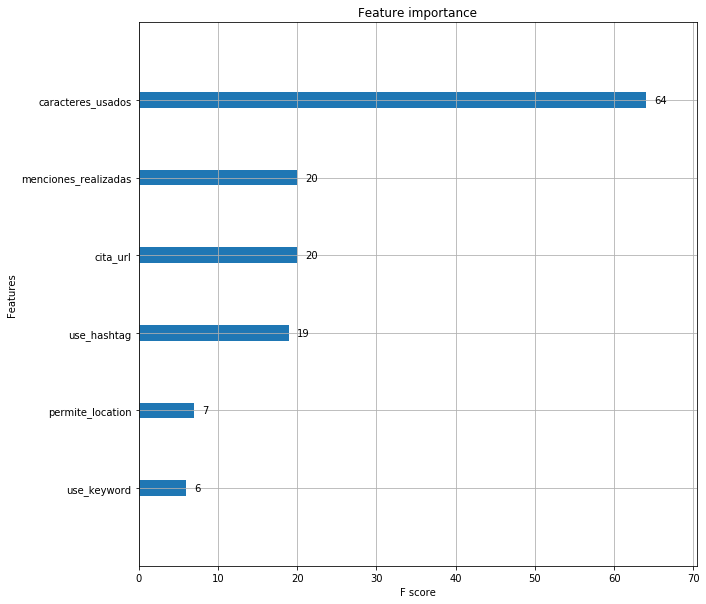

In [192]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Test Kaggle


In [193]:
test_data['prediction'] = xgbRegressor.predict(test_data[features])

In [194]:
submit_kaggle = pd.DataFrame({'id':test_data['id'],'target':test_data['prediction']})

In [195]:
submit_kaggle['target'] = submit_kaggle['target'].transform(lambda x: 0 if x < 0.5 else 1)
#submit_kaggle['target'] = submit_kaggle['target'].transform(lambda x: 1.0 if x > 1.0 else x)

In [202]:
submit_kaggle.to_csv('submit_kaggle_.csv',index=False)

In [203]:
submit_kaggle

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
